In [36]:
import os
import io
import itertools
import logging
import argparse
import contextlib2
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
from pathlib import Path
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def bytes_list_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))


def float_list_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [67]:
def flatten(xs):
    return list(itertools.chain(*xs))

def get_data(path):
    ids = [o for o in os.listdir(path) if os.path.isdir(os.path.join(path, o))]
    ids.sort()
    cat_num = len(ids)

    id_dict = dict(zip(ids, list(range(cat_num))))
    paths = []
    labels = []
    for i in ids:
        cur_dir = os.path.join(path, i)
        fns = os.listdir(cur_dir)
        paths.append([os.path.join(cur_dir, fn) for fn in fns])
        labels.append([id_dict[i]] * len(fns))

    return flatten(paths), flatten(labels)

def open_sharded_output_tfrecords(exit_stack, base_path, num_shards):
    """Opens all TFRecord shards for writing and adds them to an exit stack.

    Args:
    exit_stack: A context2.ExitStack used to automatically closed the TFRecords
        opened in this function.
    base_path: The base path for all shards
    num_shards: The number of shards

    Returns:
    The list of opened TFRecords. Position k in the list corresponds to shard k.
    """
    tf_record_output_filenames = [
        '{}-{:05d}-of-{:05d}'.format(base_path, idx, num_shards) for idx in range(num_shards)]

    tfrecords = [
        exit_stack.enter_context(tf.io.TFRecordWriter(file_name))
        for file_name in tf_record_output_filenames
    ]

    return tfrecords


def create_tf_example(filename, label):

    with tf.io.gfile.GFile(filename, mode='rb') as f:
        encoded_jpg = f.read()
        image = Image.open(io.BytesIO(encoded_jpg))
        image_width, image_height = image.size

    feature_dict = {
        'image/width': int64_feature(image_width),
        'image/height': int64_feature(image_height),
        'image/filename': bytes_feature(filename.encode('utf8')),
        'image/encoded': bytes_feature(encoded_jpg),
        'image/label': int64_feature(label)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature_dict))

def combine_datasets(data_paths):
    all_paths, all_labels = [], []
    id_start = 0
    for path in data_paths:
        paths, labels = get_data(path)
        labels = np.array(labels) + id_start
        all_paths.extend(paths)
        all_labels.extend(labels)

        id_start += np.max(labels) + 1
    return all_paths, all_labels

def create_tf_records(data_paths, output_path, n_shards):

    with contextlib2.ExitStack() as tf_record_close_stack:
        
        base_output_path = output_path + '/data.tfrecords'
        output_tfrecords = open_sharded_output_tfrecords(tf_record_close_stack, base_output_path, n_shards)
        
#         paths, labels = get_data(data_path)
        paths, labels = combine_datasets(data_paths)
        paths, labels = shuffle(paths, labels)
        print("%d images found" % len(paths))

        for i, (path, label) in tqdm(enumerate(zip(paths, labels))):
            tf_example = create_tf_example(path, label)
            shard_idx = i % n_shards
            output_tfrecords[shard_idx].write(tf_example.SerializeToString())               
            
        print('finished writing')

        # img = np.array(Image.open(images[0]), dtype=np.uint8)

In [68]:
def create_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

# Write tfrecord

In [72]:
data_paths = ['/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_32', 
              '/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_20']
output_path = '/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords'

create_dir(output_path)
create_tf_records(data_paths, output_path, 10)

144 images found



finished writing


# Read tfrecord

In [73]:
output_path ='/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords/'
tfrecords = [f'{output_path}/{f}' for f in tf.io.gfile.listdir(output_path)]
tfrecords

['/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords//data.tfrecords-00003-of-00010',
 '/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords//data.tfrecords-00006-of-00010',
 '/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords//data.tfrecords-00009-of-00010',
 '/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords//data.tfrecords-00004-of-00010',
 '/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords//data.tfrecords-00000-of-00010',
 '/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords//data.tfrecords-00005-of-00010',
 '/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords//data.tfrecords-00001-of-00010',
 '/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords//data.tfrecords-00008-of-00010',
 '/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords//data.tfrecords-00007-of-00010',
 '/home/cocoza4/datasets/lfw_sample_mtcnnpy_112_tfrecords//data.tfrecords-00002-of-00010']

In [80]:
def parse_example(proto):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/label': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64)
    }
    tf_example = tf.io.parse_single_example(proto, feature_description)
    return tf_example

def _preprocess(image, training):
    if training:
        image = tf.image.random_flip_left_right(image)
    image = tf.cast(image, tf.float32)
    image -= 127.5
    image *= 0.0078125
    return image

def preprocess_tf_example(example, training=True):
    width = example['image/width']
    height = example['image/height']
    label = example['image/label']
    image = tf.io.decode_image(example['image/encoded'])
    return _preprocess(image, training=training), label

class TFRecordDataGenerator:
    
    def __init__(self, data_dir, batch_size):
        self.data_dir = data_dir
        self.batch_size = batch_size

    def _tfrecord_files(self):
        return [f'{self.data_dir}/{f}' for f in tf.io.gfile.listdir(self.data_dir)]

    def steps_per_epoch(self):
        tfrecords = self._tfrecord_files()
        ds = (tf.data.TFRecordDataset(filenames=tfrecords)
                .batch(self.batch_size))
        steps = 0
        for _ in ds:
            steps += 1
        return steps
    
    def generate(self, example_parser, preprocess_fn=None, shuffle_buffer=200000):
        tfrecords = self._tfrecord_files()

        ds = (tf.data.TFRecordDataset(filenames=tfrecords)
            .cache()
            .shuffle(shuffle_buffer)
            .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
            .map(example_parser, num_parallel_calls=tf.data.experimental.AUTOTUNE))

        if preprocess_fn:
            ds = ds.map(preprocess_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        ds = ds.batch(self.batch_size)
        return ds
    
gen = TFRecordDataGenerator(output_path, 5)
gen

In [81]:
gen.steps_per_epoch()

29

In [82]:
for inputs, targets in gen.generate(parse_example, preprocess_fn=preprocess_tf_example):
    print(inputs.shape, targets)

(5, 112, 112, 3) tf.Tensor([12 30 24 23  9], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([ 8  8 24  8 25], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([ 6 10 26 14  8], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([ 9  3  9 22 12], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([24 25  8 16  3], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([25  7 12  9 26], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([25 10  7 30 28], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([ 8 23 25  2 26], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([ 8 14  8  8 24], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([24 14 25  3 19], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([ 8  5 24 24  8], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([ 8 10  9 27  1], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([14 25 19 25 30], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.Tensor([17 26 19 10 13], shape=(5,), dtype=int64)
(5, 112, 112, 3) tf.

In [77]:
n_channels = 3

def parse_example(proto):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/label': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64)
    }
    tf_example = tf.io.parse_single_example(proto, feature_description)
    return tf_example

def _preprocess(image, training):
    if training:
        image = tf.image.random_flip_left_right(image)
    image = tf.cast(image, tf.float32)
    
    image -= 127.5
    image *= 0.0078125
    return image

def preprocess_tf_example(example, training=True):
    width = example['image/width']
    height = example['image/height']
    label = example['image/label']
    image = tf.io.decode_image(example['image/encoded'])#.reshape((height, width, n_channels))
    image = tf.image.resize(image, size=[height, width])
    return _preprocess(image, training=training), label
    

def preprocess(path, training=True):
    raw = tf.io.read_file(path)
    image = tf.image.decode_image(raw)
    if training:
        image = tf.image.random_flip_left_right(image)
    image = tf.cast(image, tf.float32)
    
    image -= 127.5
    image *= 0.0078125
    
    return image

ds = (tf.data.TFRecordDataset(filenames=tfrecords)
      .map(parse_example))
ds

<MapDataset shapes: {image/encoded: (), image/height: (), image/label: (), image/width: ()}, types: {image/encoded: tf.string, image/height: tf.int64, image/label: tf.int64, image/width: tf.int64}>

In [127]:
for tf_example in ds.take(1):
    width = tf_example['image/width'].numpy()
    height = tf_example['image/height'].numpy()
    label = tf_example['image/label'].numpy()
    image = tf.io.decode_image(tf_example['image/encoded']).numpy().reshape((height, width, 3))

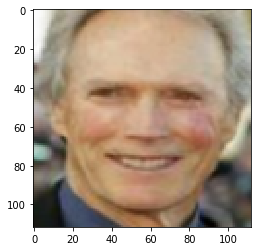

In [128]:
plt.imshow(image)

In [45]:
paths, labels = get_data('/home/cocoza4/datasets/lfw_sample_mtcnnpy_112')
paths = flatten(paths)
labels = flatten(labels)

In [46]:
example = create_tf_example(paths[0], labels[0])

In [47]:
example

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\211PNG\r\n\032\n\000\000\000\rIHDR\000\000\000p\000\000\000p\010\002\000\000\000I\202c\034\000\000R\022IDATx\234u\375\351\222dKr&\210\351fv\026w\017\217\210\214\\\356\255*\240\001\364\306\3414gdz83\024\376\340\033\3619\370:|\003\016\311\026a\003\315fO\357\230F\243\201BU\335-\227\010_\3169f\246\013\177\230G\326\005(t\tI\211\314\214\305\335\\M\227O?\375\024\377\257\377\227\3773\021\023\021D\000\200\273\233\231\231\251ii\265\224\245\224R\266uY\327\313\272\\\326\355\264\224/\327\355t\255\347\315NE\257k+\315\000]\310\367\273\371\233\367o?\274{z\367\370\360x\274\233\007\311\204\363\230\016\3634\317\363n\034\307a\030r\036\247!\017#\2610\263\210\210\010\000E\004\"\022\"@ \004D\270{\270ZSw\217\010\"\212\210\326\232\252\232Y\377\004\000\372s\206\327\207\231\251Z\255\2655u\013373s\255Z\2537\026\222ap\360u+\327u\273,\333\272\325\253z1#B\021\3119\217\343\230r\036\3061\347L\314\021\000\310L\202H\314\375)\